In [2]:
from torch_geometric.datasets import Coauthor, CitationFull, Reddit2
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit
from torch_geometric.utils import homophily
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from tqdm.notebook import tqdm
from utils import *
import pandas as pd
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
from functools import partial
import pickle as pkl
import os

%load_ext autoreload
%autoreload 2


In [3]:
dataset = Reddit2('data/Reddit2')
data = dataset[0]
test_subgraph = data.subgraph(data.test_mask)
test_subgraph

Data(x=[55334, 602], edge_index=[2, 1615610], y=[55334], train_mask=[55334], val_mask=[55334], test_mask=[55334])

In [4]:
homophily(data.edge_index, data.y, method='node')

0.8128384351730347

In [5]:
G = to_networkx(test_subgraph).to_undirected()

In [6]:
G

In [7]:
def get_nbhd_weights(G, node, k, geom=True):
    # Get dict containing nodes -> shortest path to node (i.e. depth).
    node_depth_map = pd.Series(nx.single_source_shortest_path_length(G, node, cutoff=k), name='distance')
    node_depth_map.index.name = 'node_id'
    node_depth_map = node_depth_map.drop(node) # Remove the node itself from list.
    node_depth_map = node_depth_map.reset_index()

    if geom:
        node_depth_map['weight'] = (0.5)**(node_depth_map['distance'] - 1)  # Weight =
    else:
        node_depth_map['weight'] = 1
    return node_depth_map

In [8]:
exp_path = 'experiments/14-09-2022_23-49-12_Reddit2_SHADOW'
preds_path = os.path.join(exp_path, 'preds.pkl')
with open(preds_path, 'rb') as f:
    preds = pkl.load(f)
# preds = preds[lcc_nodes]
# test_x = test_subgraph.x[lcc_nodes].numpy()
# test_y = test_subgraph.y[lcc_nodes].numpy()
preds = pd.DataFrame(preds)
test_x = pd.DataFrame(data.x[data.test_mask].numpy())
test_y = pd.DataFrame(data.y[data.test_mask].numpy())

print(len(preds))
print(len(test_x))
print(len(test_y))

55334
55334
55334


In [9]:
probs = test_y.value_counts() / len(test_y)
probs.name = 'Proportion'
probs.index.name = 'Class'
probs
sum(probs**2)

0.05173550222890036

In [8]:
preds

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,2.097040e-04,4.343497e-05,2.734680e-06,3.046737e-09,5.720815e-05,5.921852e-03,1.587953e-02,2.869732e-02,5.169243e-07,4.401381e-02,...,1.367339e-01,5.736105e-03,1.652083e-04,2.590278e-07,5.223031e-06,1.842429e-04,9.304295e-02,5.159779e-04,5.132282e-02,1.318013e-02
1,4.030139e-03,1.080441e-07,4.043911e-12,5.465040e-06,2.608795e-12,3.324255e-16,1.467974e-03,4.203566e-04,2.617328e-19,7.660101e-05,...,1.711264e-16,7.365445e-07,4.019323e-18,6.278524e-19,2.717979e-08,5.526345e-17,1.164845e-10,1.963363e-03,3.042301e-10,1.914610e-04
2,7.279528e-04,1.940651e-06,1.357225e-09,1.762215e-05,1.807786e-09,3.101254e-12,1.248065e-01,9.260973e-05,5.098856e-16,1.697828e-04,...,1.147299e-12,2.209316e-05,1.661342e-14,7.233445e-19,1.126423e-07,3.941233e-12,6.844430e-07,2.091096e-03,1.625506e-06,2.657857e-03
3,9.985110e-01,9.854977e-08,7.976008e-12,9.085338e-09,1.915550e-12,3.804032e-29,2.007727e-13,3.160819e-05,4.512987e-23,5.974614e-14,...,7.507510e-32,3.174714e-08,1.395714e-22,9.487998e-16,6.219537e-11,4.334722e-22,8.264773e-20,2.372872e-11,1.253602e-17,1.301402e-08
4,1.782998e-04,8.665255e-04,7.884552e-10,9.915460e-01,4.654495e-12,7.620431e-28,6.752037e-09,4.951878e-12,2.443330e-22,4.111193e-15,...,3.767835e-32,2.215425e-11,2.125272e-23,1.693666e-22,5.986276e-09,2.925249e-18,3.563842e-19,1.570850e-07,1.998879e-15,2.493340e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55329,4.743563e-05,3.541026e-04,6.823400e-05,2.296829e-06,8.827064e-05,1.929262e-10,3.815996e-02,1.328551e-07,2.812631e-12,1.132073e-07,...,2.263782e-12,1.981310e-03,1.143316e-10,1.554700e-18,5.258526e-08,1.939701e-05,6.814365e-04,2.604433e-06,9.339639e-03,3.185757e-03
55330,8.442882e-09,1.708048e-08,2.871376e-07,8.706020e-09,6.936628e-08,2.549154e-07,3.233491e-04,3.211103e-09,9.302781e-07,1.760841e-04,...,1.087709e-13,3.836446e-07,2.058630e-08,3.680561e-11,2.529937e-01,6.540254e-12,3.107405e-07,6.937185e-02,9.642009e-07,3.883517e-01
55331,3.889793e-16,7.185902e-17,8.206583e-11,3.145602e-19,4.325720e-11,6.968249e-08,6.553013e-07,2.972108e-15,5.720495e-10,1.944641e-07,...,3.288603e-17,7.288298e-09,1.517237e-11,4.365585e-20,1.076930e-05,9.920968e-16,5.967110e-07,3.736209e-07,9.839296e-08,9.720272e-03
55332,9.968169e-11,4.214753e-08,2.494031e-01,6.329249e-17,5.900053e-01,8.186513e-11,1.446010e-10,1.935960e-14,1.051648e-05,2.084080e-15,...,1.254201e-18,1.105592e-03,1.875736e-05,6.661903e-14,8.580054e-09,1.073210e-02,1.081247e-04,1.954805e-15,3.160506e-03,5.327676e-05


In [9]:
G.number_of_nodes()

55334

In [10]:
## Compute the NAPS prediction set for each node in advance.
alpha = 0.1
cutoff = 500
quantiles_nb = []
def calibrate_nbhd(node):
    nbs = get_nbhd_weights(G, node, k=2, geom=False)
    nb_ids = nbs['node_id'].values
    if cutoff <= len(nb_ids):
        quantile = calibrate(preds.loc[nb_ids].values,
                             np.squeeze(test_y.loc[nb_ids].values), alpha)
        return {node: quantile[0]}
quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)

/tmp/ipykernel_237763/666642696.py:12: TqdmWarning: Iterable length 55334 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  quantiles_nb = process_map(calibrate_nbhd, list(G.nodes), max_workers=12)


  0%|          | 0/55334 [00:00<?, ?it/s]

In [11]:
nz = [p for p in quantiles_nb if p is not None]
res = {}
for p in nz:
    res.update(p)
nbhd_quantiles = pd.Series(res, name='quantile')
nbhd_quantiles
lcc_nodes = nbhd_quantiles.index.values
sets_nb = predict(preds.loc[lcc_nodes].values, nbhd_quantiles.values[:, None])
sets_nb = pd.Series(sets_nb, index=lcc_nodes, name='set')

In [12]:
n_trials = 100
n_calib = 1000

In [18]:
nb_stats = []
full_stats = []
# with mp.Pool(12) as p:
for k in tqdm(range(n_trials)):
    ## Sample the prediction nodes.
    pred_nodes = np.random.choice(lcc_nodes, size=n_calib, replace=False)
    # Neighbourhood calibration is pre-computed, so just get prediction sets for them.
    nb_stats.append(evaluate_predictions(sets_nb[pred_nodes].values,
                                         test_x.loc[pred_nodes].values,
                                         np.squeeze(test_y.loc[pred_nodes].values)
                                         ))
    # Full calibration
    quantile = calibrate(preds[~preds.index.isin(pred_nodes)].values,
                         np.squeeze(test_y[~test_y.index.isin(pred_nodes)].values), alpha)
    sets_full = predict(preds.loc[pred_nodes].values, quantile)
    full_stats.append(evaluate_predictions(sets_full,
                                           test_x.loc[pred_nodes].values,
                                           np.squeeze(test_y.loc[pred_nodes].values)))


  0%|          | 0/100 [00:00<?, ?it/s]

,coverage,set_size,cc_set_size
count,100.000000,100.000000,100.000000
mean,0.895710,1.637180,1.696942
std,0.008739,0.044127,0.043730
min,0.873000,1.502000,1.583982
25%,0.890000,1.608250,1.679598
50%,0.896000,1.638500,1.698829
75%,0.901000,1.665250,1.724590
max,0.918000,1.756000,1.810307


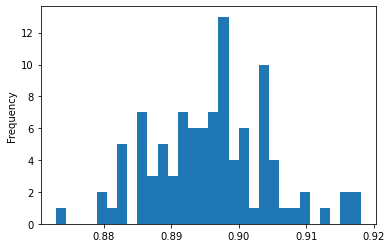

In [19]:
nb_df = pd.DataFrame(nb_stats, columns=['coverage', 'set_size', 'cc_set_size'])
nb_df['coverage'].plot(kind='hist', bins=30)
nb_df.describe()

,coverage,set_size,cc_set_size
count,100.00000,100.000000,100.000000
mean,0.92162,2.033830,2.085228
std,0.00804,0.058733,0.058051
min,0.90300,1.849000,1.934498
25%,0.91575,1.995000,2.052362
50%,0.92200,2.032500,2.087833
75%,0.92700,2.068250,2.120776
max,0.93800,2.180000,2.230176


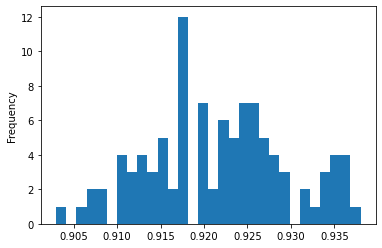

In [20]:
full_df = pd.DataFrame(full_stats, columns=['coverage', 'set_size', 'cc_set_size'])
full_df['coverage'].plot(kind='hist', bins=30)
full_df.describe()